# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer

-Work in progress (last updated:04/03/2023)-

A. MOTIVATION

ИК-спектроскопия является универсальным и точным методом химической идентификации, поскольку каждое соединение обладает уникальными ИК-спектральными характеристиками; однако спектральные характеристики, как правило, неоднозначны. Интерпретация вручную часто отнимает много времени и может привести к непоследовательным, ошибочным результатам. Следовательно, существует потребность в быстрой, точной и воспроизводимой альтернативе ручному переводу.

B. Цель

Целью этой программы является автоматизация процедуры интерпретации ИК-спектра известного соединения путем присвоения его полос поглощения имеющимся в молекуле химическим связям или типам колебаний.

C. План

Для реализации задумки предлагается решить следующие задачи:

1. Исходя из списка веществ NIST получить таблицу, содержащую данные про соединения (CAS, название, брутто-формула, молекулярная масса, элементы в составе, SMILE, SELFIE, InChi обозначения, список имеющихся в структуре связей и функциональных групп.
2. Получить ИК-спектры из списка химических веществ, по CAS ключу.
3. Обработать спектры, приведя их к единому виду и форме. Провести интерполяцию для получения спектров с единым шагом и желательно в едином диапазоне волновых чисел.
4. Построить соответствие между спектрами и labels, разобраться с типами и количестом labels, осуществить подбор правильного embending для кодирования label.
5. Визуализировать статистику по выборке, оценить баланс классов.
6. Создать объект torch.DataSet, разбить выборку на test, train, val с учётом дисбаланса.
7. Далее работу перевести в другой блокнот для создания и обучения модели.

NOTES
1. Получен список веществ, создана таблица.
2. Скачаны спектры более 5000 соединений. 
3. Разработаны функции для сбора данных label на основе таблицы и существующих спектров.

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [ ]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 16711, done.
remote: Counting objects: 100% (1868/1868), done.
remote: Compressing objects: 100% (1834/1834), done.
remote: Total 16711 (delta 42), reused 1851 (delta 33), pack-reused 14843
Receiving objects: 100% (16711/16711), 142.30 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (402/402), done.
Updating files: 100% (16617/16617), done.


# Obj. 1 Получение таблицы данных: Task 1. Сохранение периодической таблицы химических элементов:

In [ ]:
#create an ordered dictionary. In this case, order of elements is important.
import collections

# periodic_table['element_name']=['atomic_number','atomic_mass']
periodic_table = collections.OrderedDict()  # initialize dictionary.


def create_periodic_table(file_name):
    """ Read a text file line-by-line and extract information for: atomic number, atomic symbol, and relative atomic mass 

        The author is aware of at least one python periodic elements package (e.g., https://pypi.python.org/pypi/periodictable),
        but chose to implement a different approach.
    """

    file = open(file_name, 'r')  # open a file to read

    for line in file:  # read file line-by-line, extract values, and store into a dictionary

        if line.startswith('Atomic Number'):
            line = line.replace(" ", "")
            value1 = line.split('=', 1)

        if line.startswith('Atomic Symbol'):
            line = line.replace(" ", "")
            key = line.split('=', 1)

        if line.startswith('Relative Atomic Mass'):
            line = line.replace(" ", "")
            value2 = line.split('=', 1)

            # Store values into dictionary only if the element is unique.
            # Otherwise, the atomic mass will be override by isotope's atomic
            # mass.
            if key[1].strip() not in list(periodic_table.keys()):
                periodic_table[key[1].strip()] = [
                    value1[1].strip(), value2[1].strip()]
            else:
                pass

    return periodic_table

# End of functions

In [ ]:
# 1-1a. Call out function
file_name = '/content/IR_expert_system/data/NIST_periodic_table.txt'
periodic_table = create_periodic_table(file_name)

# 1-1b.Test out dictionary by calling out the element keys
print(list(periodic_table.keys()))
print("\n")
print("Number of dictinct elements in the dictionary:", len(periodic_table))

['H', 'D', 'T', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


Number of dictinct elements in the dictionary: 120


## Obj. 1 Task2: Получение таблицы из списка соеинений NIST и расчёт молярной массы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re  # for string manipulations
import requests
#import peakutils
from bs4 import BeautifulSoup  # for webscraping
#from peakutils.peak import indexes as index_utils  # for peak picking


def read_and_clean_nist_chem_list(no_of_files=72619):
    """ Read and clean a stored csv file called "NIST_chemicals_list.csv" 

    Args:
    no_of_files=specifies how many files to read from the list. The max. no. is 72619.

    Returns:
    a NIST chemicals list dataframe.

    """

    # read file
    col_names = ['Name', 'Formula', 'CAS']
    # Rename columns
    df = pd.read_csv("/content/IR_expert_system/data/NIST_chemicals_list.csv", header=1, names=col_names)
    # Remove rows that have null objects and keep only rows with no na values
    df = df.dropna()
    # make CAS the index column
    df = df.set_index('CAS')

    return df

    
def extract_unique_elements(df):
    """Given a pandas DataFrame containing a column of chemical formula, return the DataFrame 
        with an additional column containing unique elements in the formula called df['Elements']
    
        Args:
        df_Formula=a column of chemical formula in a pandas DataFrame
        Return:
        a list of unique elements
    """

    #1a. check for formulas that contain ')n' and remove it
    ##df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')   
    df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','') 
    #1b. check for formulas that contain '.xW' and remove it
    df.loc[df['Formula'].str.contains('xW')==True,'Formula']=df[df['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1c. check for formulas that contain '.XH2O' and remove it
    df.loc[df['Formula'].str.contains('XH2O')==True,'Formula']=df[df['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1d. check for formulas that contain 'xC6' and remove it
    df.loc[df['Formula'].str.contains('xC6')==True,'Formula']=df[df['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')

    
    #2. apply regex to extract unique elements in chemical formula
    df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers
    #3. df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*') 
    df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*') 
    return df


def filter_by_elements(df, elements_list):
    """ Filter compounds to contain any, but not exceeding the elements on the specified list: elements_list s

    Args:
    df=specify a dataframe on which we want to perform filtering by elements.
    elements_list=provide a list of elements in which the desired compounds contain, e.g., ['C', 'O', 'H']

    Returns:
    returns compounds that contain the listed elements.

    """

    # Create a blank pandas DataFrame
    new_df = pd.DataFrame()

    for i, element in enumerate(df.Formula):
        # strip chemical formula and leave out only the alphabets
        s_proc = re.sub('[^a-zA-Z]+', '', element)
        for allowed_element in elements_list:
            # subtract stripped formula with elements list
            s_proc = s_proc.replace(allowed_element, "")
            #print("s_proc:", s_proc)
            # If the stripped formula is completely anihilated, then all elements must have matched
            # Thus, append compound to the new DataFrame
            if (s_proc == ""):
                #    print("s_proc:", s_proc)
                new_df = new_df.append(df.iloc[i, :])
            # s_proc=re.findall('\D+', each) #extract only letters

    # relabel index column
    new_df.index.name = "CAS"
    return new_df  # returns a list


def calc_molec_weight(nist_chem_list, periodic_table):
    """ Calculate molecular weight, Mw, given a chemical formula, df.Formula 
    #ref.: https://stackoverflow.com/questions/41818916/calculate-molecular-weight-based-on-chemical-formula-using-python

    Args:
    nist_chem_list=a pandas DataFrame from which Mw will be calculated.
    periodic_table=a periodic table dictionary from which the atomic weight of each element can be retrieved.

    Returns:
    the same dataframe, but with an extra column added. This extra column is labelled as 'Mw'.

    """

    #1a. check for formulas that contain '.xW' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xW'),'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1b. check for formulas that contain '.XH2O' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('XH2O')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1c. check for formulas that contain 'xC6' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xC6')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')

    
    for i, each in enumerate(nist_chem_list.Formula):

        # separate atomic symbols from atomic ratios
        total_weight = 0  # initialize total weight
        s = re.findall('([A-Z][a-z]?)([0-9]*)', each)

        for elem, count in s:
            if count == '':  # For singular elements
                count = 1
            else:
                pass
            try:
                total_weight += int(count) * \
                    float(re.sub('[(#)]', '', periodic_table[elem][1]))
            except: 
                print("error:", nist_chem_list.iloc[i,1])
                continue

        # Append total weight to a new column in pandas DataFrame
        nist_chem_list.loc[nist_chem_list.index[i], 'Mw'] = total_weight
    return nist_chem_list
    

def create_func_group_table():
    """ Scrape a table from wikipedia and load it into a pandas DataFrame 

    Args:
    None

    Returns:
    df=a pandas DataFrame of functional group classification.

    """

    # Request information from wikipedia
    res = requests.get(
        "https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups")

    # Create a BeautifulSoup class
    soup = BeautifulSoup(res.content, 'lxml')

    # Extract info. from a table
    table = soup.find_all(class_="wikitable")[0]

    # Load table info. into a Pandas DataFrame
    df = pd.read_html(str(table), header=0)[0] #, index_col='Chemical class')[0]
    
    return df


# def pick_peaks(title_name, x, y):
#     """ Given x and y values, pick peaks using PeakUtils python package by identifying peak maxima and plot graphs. 
#         This algorithm is a 1-D search. In the calculation, it doesn't account for the x-values.

#         ref.: https://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work

#     parameters:
#     The sensitivity of the peak picking algorithm can be varied by changing the thres and min-dist 
#     in the index_utils object (see below).

#     Args:
#     title_name=specify the title of the data, which will be displayed on the final plot. 
#     x=specfy x values.
#     y=specfy y values.

#     Returns:
#     plots spectra with marked peaks.

#     """

#     # print('Detect peaks with minimum height and distance filters.')
#     index_utils = index_utils(np.array(y), thres=0.02 / max(y), min_dist=5)
#     # print('Peaks are: %s' % (indexes))

#     x_max = []
#     y_max = []

#     for each in index_utils:
#         x_max.append(x[each])
#         y_max.append(y[each])

#     # plot the x,y pair of the identified maxima data points, i.e., indexes,
#     # max_peaks:
#     plt.plot(x, y)
#     plt.plot(x_max, y_max, 'rD', alpha=0.3)

#     plt.title(title_name)
#     plt.ylabel("Absorbance")  # All units are transformed to absorbance
#     plt.xlabel("Wavenumber, cm-1")  # all units are transformed into 1/cm

# # End of functions

In [ ]:
# 1-2a. Generate nist chemicals list by calling out the read_and_clean_nist_chem_list function 
nist_chem_list = read_and_clean_nist_chem_list()
# print(df.head()) #check

# 1-2b. Calculate molecular weight of compounds and append to
# nist_chem_list: nist_chem_list_app1
##nist_chem_list_app1 = calc_molec_weight(filtered_nist_chem_list, periodic_table)
nist_chem_list_Mw = calc_molec_weight(nist_chem_list, periodic_table)
#print(nist_chem_list_Mw.head(5)) #check

#1-2c
#Extract unique elements and append a new column called 'Elements'
nist_chem_list_Mw_el=extract_unique_elements(nist_chem_list_Mw)
print(nist_chem_list_Mw_el.head(5)) #check


<ipython-input-4-592addf35fbd>:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')


                                                        Name     Formula  \
CAS                                                                        
100-00-5                          Benzene, 1-chloro-4-nitro-   C6H4ClNO2   
100-01-6                                      p-Nitroaniline    C6H6N2O2   
100-02-7                                    Phenol, 4-nitro-     C6H5NO3   
100043-29-6                                     2H-Tetrazole       CH2N4   
100046-00-2  2,2,4,4',6,6'-Hexamethylazobenzene N,N'-dioxide  C18H22N2O2   

                     Mw          Elements  
CAS                                        
100-00-5     156.993056  [C, H, Cl, N, O]  
100-01-6     138.042927      [C, H, N, O]  
100-02-7     139.026943      [C, H, N, O]  
100043-29-6   70.027946         [C, H, N]  
100046-00-2  298.168128      [C, H, N, O]  


<ipython-input-4-592addf35fbd>:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers


In [ ]:
#WORK IN PROGRESS

# 1-2d. Create a functional group table DataFrame
func_group_table = create_func_group_table()
#print(func_group_table.head())

#strip off '-'
func_group_table.loc[func_group_table['Suffix'].str.contains('-')==True,'Suffix']=func_group_table[func_group_table['Suffix'].str.contains('-')==True]['Suffix'].str.replace('-','')
func_group_table.loc[func_group_table['Prefix'].str.contains('-')==True,'Prefix']=func_group_table[func_group_table['Prefix'].str.contains('-')==True]['Prefix'].str.replace('-','')
print(func_group_table)

#Create a new column with functional group assignment
#WORK IN PROGRESS

"""
for i,j in enumerate(nist_chem_list_Mw_el.Name):
    #print(nist_chem_list_Mw_el.Name.str.contains(j))
    print(nist_chem_list_Mw_el.Name.str.contains(j))
        #print("Yes")
        #print(nist_chem_list_Mw_el.Name.iloc[i])
"""


### Группировка соединений в группы по типам

In [ ]:
#Check for chemicals that contains certain elements
#I. Generate elements list

#A. organic compounds
organic=['C','H','O','N','S','P','B','Cl', 'F', 'I', 'Br'] 

#B. Transition metals
t_metals=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(22,32):
        t_metals.append(j)
    elif i in range(40,50):
        t_metals.append(j)
    elif i in range(73,82):
        t_metals.append(j)

print(t_metals)

#C. lanthanides and actinides list is no 57-71 and 89-103
f_block=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(58,73):
        f_block.append(j)
    elif i in range(90,105):
        f_block.append(j)
print('\n')
print(f_block)

##############################
##############################
#II. group elements based on the elements list

#A. organic compounds
nist_chem_list_organic=[]
nist_chem_list.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list.csv") #Saving csv file
#Return chemicals with at least one matching elements in the list
[nist_chem_list_organic.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(organic))==0] #Check for matching elements

nist_chem_list_organic=pd.DataFrame(nist_chem_list_organic) #convert list into a dataframe

nist_chem_list_organic = nist_chem_list_organic.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
#print(nist_chem_list_organic.head())
nist_chem_list_organic.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_organic.csv")  #Saving csv file
##nist_chem_list_organic.info()

#print("No. of organic compounds:", len(nist_chem_list_organic.Name))

#print(nist_chem_list[set(nist_chem_list.Elements).intersection(list1)])

#[print(nist_chem_list.Elements) if e in nist_chem_list.Elements]
#set(nist_chem_list.Elements).intersection(list1)
#nist_chem_list.columns

#B. Transition metals
nist_chem_list_t_metals=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_t_metals.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(t_metals))==0] #Check for matching elements

nist_chem_list_t_metals=pd.DataFrame(nist_chem_list_t_metals) #convert list to pandas dataframe
nist_chem_list_t_metals = nist_chem_list_t_metals.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
nist_chem_list_t_metals.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_t_metals.csv")  #Saving csv file
#print("No. of transition metals:", len(nist_chem_list_t_metals))

##nist_chem_list_t_metals.info()
#print(nist_chem_list_t_metals)

#C. lanthanides

nist_chem_list_f_block=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_f_block.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(f_block))==0] #Check for matching elements

nist_chem_list_f_block=pd.DataFrame(nist_chem_list_f_block) #convert list to pandas dataframe
nist_chem_list_f_block = nist_chem_list_f_block.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
nist_chem_list_f_block.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_f_block.csv")  #Saving csv file
#print("No. of f-blocks:", len(nist_chem_list_f_block))
#print('\n')
##nist_chem_list_lanthanides.info()
#print(nist_chem_list_lanthanides)



['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg']


['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']


## [✓] Obj. 1 Task 2 is partially completed.

The following tools have been implemented:

-For determining the unique elements present in the NIST chemicals list. 
-For filtering compounds that contain specific set of elements
-For calculating molecular weight of compounds

*Two more features that need to be implemented are:
    a. Classifying the compounds into various families of function groups: 
    ref.: https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups
    -> The function for web scraping has been created. The next step is to implement this function on the compounds.
    b. Identify peaks in each of the spectra and add a new column that lists the picked peaks.

## Obj. 1 Task 3: Сортировка таблицы (опционально)

I. Содержание различных групп химических соединений.

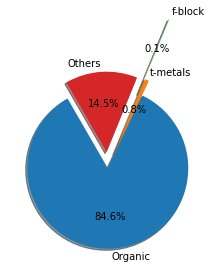

Compounds breakdown:


 Organic: 37611

 t-metals: 361

 f-block: 40

 Others: 6443

 Total: 44455


In [ ]:
#draw pie chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Organic', 't-metals', 'f-block', 'Others' 
others=len(nist_chem_list)-sum([len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block)])
sizes = [len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block), others]
explode = (0, 0.2, 1.0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=120, autopct='%1.1f%%')
#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

print("Compounds breakdown:\n")
print("\n Organic:", len(nist_chem_list_organic))
print("\n t-metals:", len(nist_chem_list_t_metals))
print("\n f-block:", len(nist_chem_list_f_block))
print("\n Others:", others)
print("\n Total:", len(nist_chem_list))


II. Распеределение молекулярных масс

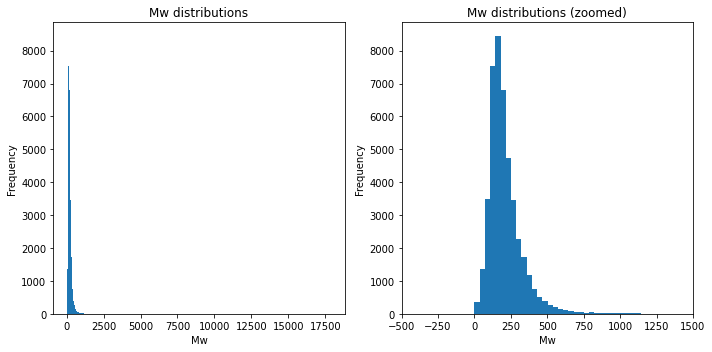

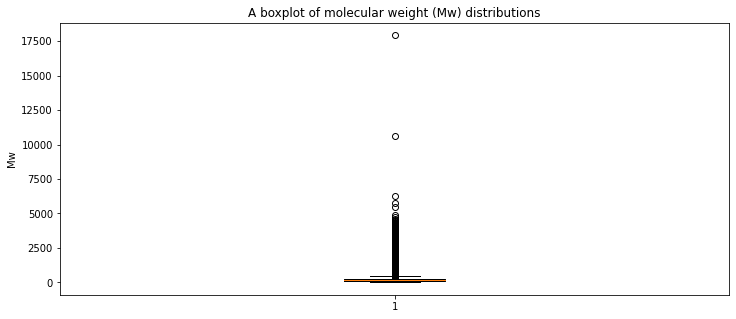



Some statistics count    44455.000000
mean       221.754239
std        231.506335
min          0.000000
25%        136.125201
50%        184.052429
75%        256.096026
max      17912.691751
Name: Mw, dtype: float64


<class 'pandas.core.frame.DataFrame'>
Index: 44455 entries, 100-00-5 to 999-97-3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      44455 non-null  object 
 1   Formula   44455 non-null  object 
 2   Mw        44455 non-null  float64
 3   Elements  44455 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.7+ MB
Data overview None


In [ ]:
# A. Generate a histogram of molecular weight distribution
# plt.figure(figsize=(20,10))

##nist_chem_list_app1.Mw.plot(kind='hist', bins=100, normed=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500)
plt.xlabel('Mw')
plt.title('Mw distributions')

plt.subplot(1,2,2)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500)
plt.xlabel('Mw')
plt.xlim(-500,1500)
plt.title('Mw distributions (zoomed)')
plt.tight_layout()

# B. show a box plot of Mw distributions
plt.figure(figsize=(12,5))

# nist_chem_list_app1.Mw.plot(kind='box')
plt.boxplot(nist_chem_list_Mw_el.Mw)

plt.title('A boxplot of molecular weight (Mw) distributions')
plt.ylabel('Mw')

plt.show()

print("\n")
print("Some statistics", nist_chem_list_Mw_el.Mw.describe())
print("\n")
print("Data overview", nist_chem_list_Mw_el.info())


In [ ]:
#check which compounds are in the outliers
#A. Mw=0
mw_eq_0=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw==0]
print("No of elements with Mw=0:", len(mw_eq_0))

#check original entries
##cas_list=['25988-63-0', '26700-39-0', '26982-20-7', '61257-62-3', '61857-39-4']
#nist_chem_list.index.name

#print(nist_chem_list.head())   
##df=pd.read_csv("data/NIST_chemicals_list.csv")    
##df.columns=['Name','Formula','CAS']
##df.head(3)

#nist_chem_list.loc['26700-39-0']
##for i in cas_list:
##    print(df[df['CAS']==i])

#B. Mw>1000
mw_gt_1000=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw>1000]
print("No of elements with Mw>1000:",len(mw_gt_1000))
#print(mw_gt_1000)
#print(mw_gt_1000.index)
#print(len(mw_gt_1000))    

#C. Check for duplicates
print("Number of chemicals in the list:", len(nist_chem_list_Mw_el.iloc[:,0]))
print("Number of chemicals with unique CAS number in the list:", len(set(nist_chem_list_Mw_el.index))) 
#There are no duplicates. Good!



No of elements with Mw=0: 5
No of elements with Mw>1000: 271
Number of chemicals in the list: 44455
Number of chemicals with unique CAS number in the list: 44455


# Obj. 2 Скачивание спектров, полученных парсингом сайта NIST

In [ ]:
import urllib.request
import requests
import pandas as pd
import time
import random
from tqdm import tqdm
def download_jcamp_from_nist(cas_list, minimum_file_size=1000, start_of_files = 0, no_of_files=20):
    """ Download jcamp files from NIST website by calling out CAS values (i.e., the df index) from chemicals DataFrame, df

    Args:
    cas_list=a list consisting of CAS no.
    size=the minimum file size at which the file will be downloaded.
    no_of_files=the number of files to download.

    Returns:
    automatically saves files into the same directory as this python program.
    print the name of the downloaded files.
    name of downloaded files

    """

    # NOTE THAT SOME OF THESE FILES TURN out to be empty.
    # Need to check file size before proceeding. Don't download if empty.
    # Files are saved in the same folder as this python script.

    # Download data based on CAS number partially

    for cas_no in cas_list[start_of_files:start_of_files+no_of_files]:
        # specify CAS no. separately
        cas_num = int(cas_no.replace("-", ""))
        url = "http://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C%s&Index=1&Type=IR" % (
            cas_num) #Changed index from 0 to 1

        try:

            # Download only if size is significant. 1000 seems optimum.
            if len(requests.get(url).content) >= 1000:
                # Strip comma, apostrophe, and space in the file name because
                # it will mess up the ability of the jcamp program to read the
                # file.
                url_ret = urllib.request.urlretrieve(url, "/content/IR_expert_system/downloaded_jcamp/%s" % (cas_no))  # save file according to its cas_no
                # save by cas no.
                # url_ret = urllib.request.urlretrieve(url, "reference/%s" %(cas_no))  # save file according to its cas_no

                print(url_ret)  # print list of downloaded compounds

                # return url_ret
        except:
            continue


# End of functions

## Obj2. Task 1: Скачивание спектров с сайта.

In [ ]:
# DOWLOADED on the PC (will be uploaded later) 
#Need to complicate the approach by filtering the types of compounds
# Call out function to download. Place downloaded files into the "downloaded_jcamp" folder.
# nist_chem_list_organic=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_organic.csv')
# cas_all_list = []
# for i in range(len(nist_chem_list_organic['CAS'])):
#     cas_all_list.append(nist_chem_list_organic['CAS'][i])

In [ ]:
#Need to complicate the approach by filtering the types of compounds
# Call out function to download. Place downloaded files into the "downloaded_jcamp" folder.
nist_chem_list_f_block=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_f_block.csv')
cas_all_list = []
for i in range(len(nist_chem_list_f_block['CAS'])):
    cas_all_list.append(nist_chem_list_f_block['CAS'][i])
nist_chem_list_t_metals=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_t_metals.csv')
for i in range(len(nist_chem_list_t_metals['CAS'])):
    cas_all_list.append(nist_chem_list_t_metals['CAS'][i])

In [ ]:
# !mkdir /content/IR_expert_system/downloaded_jcamp/

In [ ]:
# batch = 20
# dowloaded = 0
# pause = random.random()/100

# for i in tqdm(range(0, len(cas_all_list)-batch ,batch)):

#     download_jcamp_from_nist(cas_all_list, 1000,start_of_files = i, no_of_files=batch)

#     dowloaded = dowloaded+1
#     time.sleep(pause)
# print(f"Parcing in finished. {dowloaded} steps of {batch} batches succesfully done!")
# # print(nist_chem_list_organic)

On the colab it does not work properly. So I made it of the my PC and upload all spectra into the git.hub

Updating the nist_chem_list with information about existance of the IR spectra.

In [ ]:
import os
cas_with_ir = []
cas_with_ir_filepass = []
for dirpath, _, filenames in os.walk('/content/IR_expert_system/downloaded_jcamp/ir'):
  for filename in filenames:
     cas_with_ir.append(filename)
     cas_with_ir_filepass.append(os.path.join(dirpath, filename))
#print(cas_with_ir_filepass)
#print(cas_with_ir)
ir_spectra_dic = {}
ir_spectra_dic["CAS"] = cas_with_ir
ir_spectra_dic["Pass_to_file"] = cas_with_ir_filepass
# Create DataFrame
nist_ir_spectra_df = pd.DataFrame(ir_spectra_dic)
nist_ir_spectra_df

In [ ]:
nist_chem_list= nist_chem_list.reset_index()

In [ ]:
nist_ir_spectra_list = nist_chem_list.loc[nist_chem_list['CAS'].isin(cas_with_ir)]
nist_ir_spectra_list

,CAS,Name,Formula,Mw,Elements
0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"[C, H, Cl, N, O]"
1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"[C, H, N, O]"
2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"[C, H, N, O]"
5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"[C, H, Si]"
6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"[C, H, Cl, Si]"
...,...,...,...,...,...
44447,99980-28-6,"Imidazole, 4-nitro-5-(propylsulfonyl)-",C6H9N3O4S,219.031377,"[C, H, N, O, S]"
44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"[C, H, Cl, N, Cl]"
44449,99983-48-9,"Alpha,alpha-dichloropropionic acid, 2-(2,4-dib...",C11H10Br2Cl2O3,417.837375,"[C, H, Br, Cl, O]"
44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"[C, H, N, O]"


In [ ]:
nist_ir_spectra_list.set_index('CAS').join(nist_ir_spectra_df.set_index('CAS'))

,Name,Formula,Mw,Elements,Pass_to_file
CAS,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"[C, H, Cl, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"[C, H, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"[C, H, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"[C, H, Si]",/content/IR_expert_system/downloaded_jcamp/ir/...
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"[C, H, Cl, Si]",/content/IR_expert_system/downloaded_jcamp/ir/...
...,...,...,...,...,...
99980-28-6,"Imidazole, 4-nitro-5-(propylsulfonyl)-",C6H9N3O4S,219.031377,"[C, H, N, O, S]",/content/IR_expert_system/downloaded_jcamp/ir/...
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"[C, H, Cl, N, Cl]",/content/IR_expert_system/downloaded_jcamp/ir/...
99983-48-9,"Alpha,alpha-dichloropropionic acid, 2-(2,4-dib...",C11H10Br2Cl2O3,417.837375,"[C, H, Br, Cl, O]",/content/IR_expert_system/downloaded_jcamp/ir/...


## Obj2. Task 2: Uniformize units and plot spectra.

In [ ]:
from IPython.core.display import clear_output
!pip install --upgrade jcamp
clear_output()

In [ ]:
# Plot one spectra that are located in the "downloaded_jcamp" folder
# Use jcamp codes to read jcamp files using jcamp package (taken from:
# https://pypi.python.org/pypi/jcamp/1.2.1).

import jcamp
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Create an empty list to store spectra data
ref_spectra = []


# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/*')  # look for files without extension. Returns a list.

In [ ]:
from jcamp import jcamp_readfile
sample = jcamp_readfile(files[0])
print(sample)
print(sample["y"])

{'title': '2-Chloroethanamine, N-2-chloroethyl-, hydrochloride', 'jcamp-dx': 4.24, 'data type': 'INFRARED SPECTRUM', 'class': 'COBLENTZ III', 'origin': 'DOW CHEMICAL COMPANY', 'owner': 'COPYRIGHT (C) 1988 by COBLENTZ SOCIETY INC.\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.', 'date': '1964/05/13', 'names': "N,N-bis(2-chloroethyl)amine hydrochloride\n2,2'-Dichlorodiethylamine hydrochloride", 'cas registry no': '821-48-7', 'molform': 'C4 H10 Cl3 N', 'source reference': 'COBLENTZ NO. 09864', '$nist source': 'COBLENTZ', '$nist image': 'cob9864', 'spectrometer/data system': 'DOW KBr FOREPRISM-GRATING', 'instrument parameters': 'BLAZED AT 3.5, 12.0, 20.0 MICRON AND CHANGED AT 5.0, 7.5, 14.9 MICRON', 'state': 'SOLID (SPLIT MULL), FLUOROLUBE FOR 3800-1330 CM^-^1, NUJOL FOR 1330-400 CM^-^1', 'sampling procedure': 'TRANSMISSION', 'resolution': 2, 'data processing': 'DIGITIZED BY COBLENTZ SOCIETY (BATCH I) FROM H

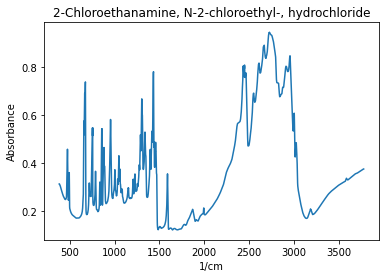

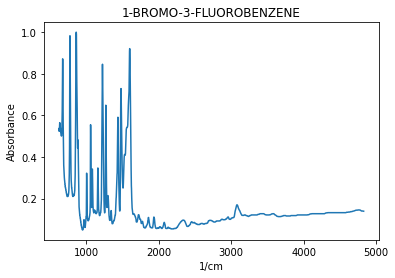

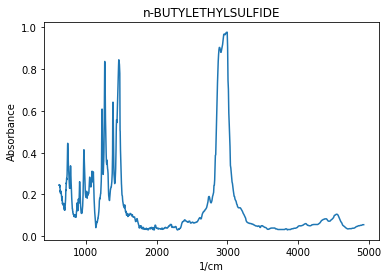

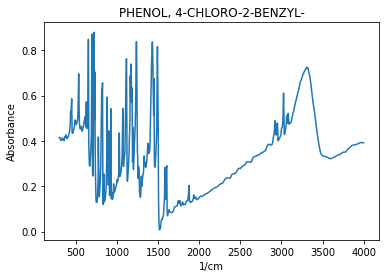

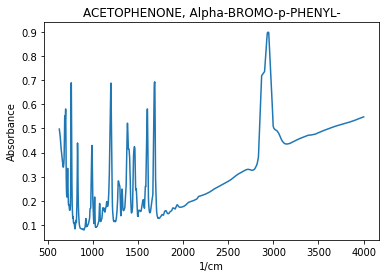

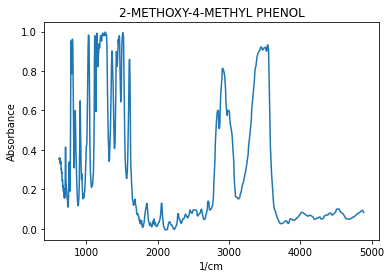

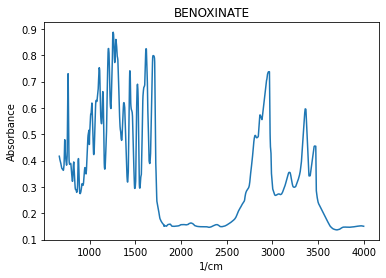

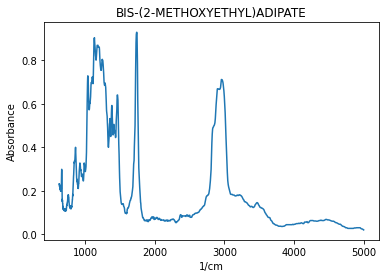

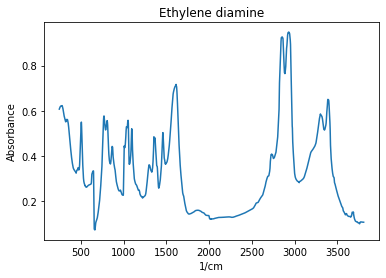

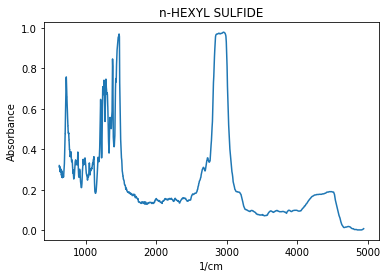

In [ ]:
# Try to read the file. If can't be read, skip it.
for i, file in enumerate(files[:10]):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        ref_spectra.append(sample)
        
        #print(ref_spectra[i])
        #print(ref_spectra[i]['x'])
        #print(ref_spectra[i]['y'])
        
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if ref_spectra[i]['yunits'] == "ABSORBANCE":
            pass 

        elif ref_spectra[i]['yunits'] == "TRANSMISSION" or "TRANSMITTANCE":
            
            ref_spectra[i]['y'] = 1 - ref_spectra[i]['y']
            #normalize
            #ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # check xunits: if in microns, change to 1/cm
        if ref_spectra[i]['xunits'] == "MICROMETERS":
            ref_spectra[i]['x'] = 10000 / ref_spectra[i]['x']

        # uniformize data, #2:
        # normalize absorbance peaks (y-values) to between 0 and 1.
        #ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
       
        

        # Nan check
        if np.isnan(ref_spectra[i]['y']).any(): print("Reading jcamp problem! Nan observed in Y")
        
        # plot data to allow visual inspections
        plt.plot(ref_spectra[i]['x'], ref_spectra[i]['y'])
        plt.title(ref_spectra[i]["title"])
        plt.xlabel('1/cm')
        plt.ylabel('Absorbance')
        plt.show()

    except:
        # print("File can't be read, please check:", files)
         continue

##Obj2. Task 3: CAS to InChi/SMILES/SELFIES label switch

In [ ]:
from urllib.request import urlopen

#Функция для конвертации онлайн CAS номера в SMILES или Standart InChi описание молекулы

def CasToInChiconvert(cas):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + cas + '/stdinchi'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return cas

def CasToSMILESconvert(cas):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + cas + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return cas

casno = ['50-78-2', '69-72-7', '95-1E-6', '108-24-7', '31710-30-2']

for casid in casno:
    print(CasToSMILESconvert(casid))

CC(=O)Oc1ccccc1C(O)=O
OC(=O)c1ccccc1O
95-1E-6
CC(=O)OC(C)=O
Clc1c(Cl)c(Cl)c(Oc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl)c(Cl)c1Cl


In [ ]:
!pip install cirpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cirpy: filename=CIRpy-1.0.2-py3-none-any.whl size=7275 sha256=779cf5fb039163faa85ea9b43bf36519d31327889912a048619c2b2a06038b36
  Stored in directory: /root/.cache/pip/wheels/f3/eb/17/f92433a13fee7d374ef246df6adc1a58ba07f7969d72aee1f1
Successfully built cirpy


In [ ]:
import cirpy
def cirpy_cas_to_smiles(cas):
  return cirpy.resolve(cas, 'smiles')
def cirpy_cas_to_inchi(cas):
  return cirpy.resolve(cas, 'inchi')

Добавим в таблицу к имеющимся CAS ключи SMILES и InChi. Занимает порядка 20 минут. Поэтому сохранено и загружено на ГитХаб. В дальнейшем импортируется из гита. А код убран под комментарий.

In [ ]:
# from tqdm import tqdm
# smiles_list = []
# inchi_list = []

# for casno in tqdm(nist_ir_spectra_list["CAS"]):
#   smile = cirpy_cas_to_smiles(casno)
#   smiles_list.append(smile)
#   inchi_list.append(cirpy_cas_to_inchi(casno))
 
# nist_ir_spectra_list["InChi"] = inchi_list
# nist_ir_spectra_list["SMILES"] = smiles_list

# nist_ir_spectra_list

In [ ]:
# nist_ir_spectra_list.to_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")

In [ ]:
nist_ir_spectra_list = pd.read_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")
#nist_ir_spectra_list=nist_ir_spectra_list.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
nist_ir_spectra_list = nist_ir_spectra_list.dropna()
nist_ir_spectra_list

,Unnamed: 0,CAS,Name,Formula,Mw,Elements,InChi,SMILES
0,0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1
1,1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O
2,2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O
3,5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C
4,6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl
...,...,...,...,...,...,...,...,...
14661,44445,99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1
14662,44446,999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C
14664,44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl
14666,44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"['C', 'H', 'N', 'O']","InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3",Cc1ccc(cc1)[N+]([O-])=O


## Obj 2. Task 4. Создаём листы меток (функциональные группы, связи)

### Создаем список связей с вики

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def create_all_bonds_types_table():
  # Request information from wikipedia
  res = requests.get(
        "https://en.wikipedia.org/wiki/Infrared_spectroscopy_correlation_table")

  # Create a BeautifulSoup class
  soup = BeautifulSoup(res.content, 'lxml')

  # Extract info. from a table
  table = soup.find_all(class_="wikitable")[0]

  # Load table info. into a Pandas DataFrame
  df = pd.read_html(str(table), header=0)[0]
  return df

In [ ]:
all_bonds_types_table = create_all_bonds_types_table()
all_bonds_types_table

,Bond,Type of bond,Specific type of bond,Absorption peak (cm−1),Appearance
0,C─H,alkyl,methyl,1260,strong
1,C─H,alkyl,methyl,1380,weak
2,C─H,alkyl,methyl,2870,medium to strong
3,C─H,alkyl,methyl,2960,medium to strong
4,C─H,alkyl,methylene,1470,strong
...,...,...,...,...,...
87,N─O,nitro compounds,aromatic,1520,lower if conjugated
88,N─O,nitro compounds,aromatic,1350,lower if conjugated
89,P─C,Organophosphorus compound,aromatic,1440-1460,medium
90,P─O,phosphorus oxide,bonded,1195-1250,strong


Генерируем для каждого соединения набор связей по CAS номеру.

## Obj 3. Task 4. Создаём листы меток (функциональные группы, связи)

### Типы и виды связей

In [ ]:
!pip install datamol
!pip install rdkit
clear_output()

In [ ]:
import datamol as dm

#Функция для генерации по smile набора связей

def create_bonds_table_from_mol(smile):
  if smile =='np.nan': print("There is no SMILE")
  else:
    list_of_bonds = []
    try:
      mol = dm.to_mol(smile)
      bonds = mol.GetBonds()
      
      for bond in bonds:
        begin_atom = bond.GetBeginAtom().GetSymbol()
        end_atom = bond.GetEndAtom().GetSymbol()
        bond_type = bond.GetBondType()
        if end_atom == "C": begin_atom, end_atom = end_atom, begin_atom
        list_of_bonds.append(f'{begin_atom} - {end_atom} {bond_type}')
    except AttributeError:
      list_of_bonds.append(np.nan)
      #print(f"Erorr with SMILE: {smileno} is not SMILE")
    except ValueError:
      list_of_bonds.append(np.nan)
    
    
    return list(set(list_of_bonds))


In [ ]:
from tqdm import tqdm
bond_list = []
for smileno in tqdm(nist_ir_spectra_list["SMILES"]):
    #print(smileno)
    bond_list.append(create_bonds_table_from_mol(smileno))
#print(bond_list)   
nist_ir_spectra_list['Bonds list'] = bond_list
nist_ir_spectra_list

### Функциональные группы

In [ ]:
#Функция для генерации бинарных меток присутствия функциональных групп 
#From https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning
import os
import logging
import argparse
import sys
import datamol as dm
import pandas as pd 
import numpy as np

from rdkit import Chem, RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

#from model.utils import set_logger
print('imports loaded')
func_grp_smarts = {'alkane':'[CX4;H0,H1,H2,H4]',
                   'methyl':'[CH3]',
                   'alkene':'[CX3]=[CX3]',
                   'alkyne':'[CX2]#C',
                   'alcohols':'[#6][OX2H]',
                   'amines':'[NX3;H2,H1;!$(NC=O)]',
                   'nitriles':'[NX1]#[CX2]', 
                   'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
                   'alkyl halides':'[#6][F,Cl,Br,I]', 
                   'esters':'[#6][CX3](=O)[OX2H0][#6]',
                   'ketones':'[#6][CX3](=O)[#6]',
                   'aldehydes':'[CX3H1](=O)[#6]', 
                   'carboxylic acids':'[CX3](=O)[OX2H1]',
                   'ether': '[OD2]([#6])[#6]',
                   'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
                   'amides':'[NX3][CX3](=[OX1])[#6]',
                   'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'}

def identify_functional_groups(inchi):
    '''Identify the presence of functional groups present in molecule 
       denoted by inchi

    Args:
        root: (string) path to spectra data
        files: (list) jdx files present in root
        save_path: (string) path to store csv file
        bins: (np.array) used for standardizing
        is_mass: (bool) whether data being parsed is Mass or IR

    Returns:
        mol_func_groups: (list) contains binary values of functional groups presence
                          None if inchi to molecule conversion returns warning or error
    '''
    
    try:
        #Convert inchi to molecule
        mol = Chem.MolFromInchi(inchi, treatWarningAsError=True)   
        mol_func_grps = []
        #mol1 = dm.to_mol(inchi, sanitize=True)
        #dm.viz.to_image(mol1)
        #populate the list with group values
        for _, func_struct in func_grp_structs.items():
            
            #print(func_struct)
            dm.viz.to_image(func_struct)
            struct_matches = mol.GetSubstructMatches(func_struct)
            #print(struct_matches)
            contains_func_grp = int(len(struct_matches)>0)
            #print(contains_func_grp)
            mol_func_grps.append(contains_func_grp)
        return mol_func_grps
    except:

        return None
# def identify_bond_types(inchi):
#     '''Identify the presence of functional groups present in molecule 
#        denoted by inchi

#     Args:
#         root: (string) path to spectra data
#         files: (list) jdx files present in root
#         save_path: (string) path to store csv file
#         bins: (np.array) used for standardizing
#         is_mass: (bool) whether data being parsed is Mass or IR

#     Returns:
#         mol_func_groups: (list) contains binary values of functional groups presence
#                           None if inchi to molecule conversion returns warning or error
#     '''
    
#     try:
#         #Convert inchi to molecule
#         mol = Chem.MolFromInchi(inchi, treatWarningAsError=True)   
#         mol_func_grps = []

#         #populate the list with group values
#         for _, func_struct in func_grp_structs.items():
#             #print(func_struct)
#             struct_matches = mol.GetSubstructMatches(func_struct)
#             #print(struct_matches)
#             contains_func_grp = int(len(struct_matches)>0)
#             #print(contains_func_grp)
#             mol_func_grps.append(contains_func_grp)
#         return mol_func_grps
#     except:

#         return None
    
def save_target_to_csv(cas_inchi_df, save_path):
    '''Save the target dataframe as csv to path

    Args:
        cas_inchi_df: (pd.DataFrame) contains CAS and Inchi of molecules
        save_path: (string) path to store csv file

    Returns:
        None
    '''
    column_names = list(func_grp_structs.keys())    
    target_df = pd.DataFrame(index = cas_inchi_df.index, columns = column_names)

    #Iterate the rows, don't use df.apply since a list is being returned.
    for ind, (_, row) in enumerate(cas_inchi_df.iterrows()):
        target_df.iloc[ind, :] = identify_functional_groups(row['inchi'])
    

    target_df.dropna(inplace = True)
    target_df.to_csv(save_path)
    return target_df


imports loaded


In [ ]:
    # #Parsing the data from jdx and storing it in csv

    # func_grp_structs = {func_name : Chem.MolFromSmarts(func_smarts)\
    #                     for func_name, func_smarts in func_grp_smarts.items()}
    # print('funcgrpstruct')
    # #print(func_grp_structs)
    
    
    # logging.info('Loading inchi file from /content/IR_expert_system/data/nist_ir_spectra_list.csv')
    # inchi_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list.csv', header = 0, usecols = [1,6],\
    #                     names = ['CAS','inchi'], dtype = str)
    # #print(inchi_df)
    
    # inchi_df.dropna(inplace = True)
    # inchi_df.set_index('CAS', inplace = True)
    
    # # Create and save csv of target 
    # target_path = os.path.join('/content/IR_expert_system/data', 'target.csv')
    
    # save_target_to_csv(inchi_df, target_path)
    # target = pd.read_csv("/content/IR_expert_system/data/target.csv")
    # target

In [ ]:
# nist_ir_spectra_list_with_group = nist_ir_spectra_list.set_index('CAS').join(target.set_index('CAS'))
# nist_ir_spectra_list_with_group

In [ ]:
# nist_ir_spectra_list_with_group.to_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')

In [ ]:
nist_ir_spectra_list_with_group.csv_read('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')

# Obj 4. Task 1. Визуализация данных.

In [ ]:
#nist_ir_spectra_list_with_group = nist_ir_spectra_list_with_group.drop(["Bonds list"], axis = 1)
nist_ir_spectra_list_with_group = nist_ir_spectra_list_with_group.drop(["Unnamed: 0"], axis = 1)
nist_ir_spectra_list_with_group

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe()

,alkane,methyl,alkene,alkyne,alcohols,amines,nitriles,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
count,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.00000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000
mean,0.679565,0.618701,0.134162,0.019061,0.222186,0.129990,0.03804,0.585733,0.260062,0.117147,0.092850,0.020370,0.061355,0.250900,0.009735,0.070517,0.057428
std,0.466663,0.485726,0.340841,0.136745,0.415732,0.336306,0.19130,0.492615,0.438686,0.321608,0.290234,0.141267,0.239990,0.433549,0.098188,0.256027,0.232668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
mean_of_groups = nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe().drop(['count', 'std', 'min', '25%', '50%', '75%', 'max'])
mean_of_groups = mean_of_groups.values.tolist()
print(mean_of_groups)

[[0.6795647905759162, 0.6187009162303665, 0.13416230366492146, 0.019060863874345548, 0.22218586387434555, 0.1299901832460733, 0.03803992146596859, 0.5857329842931938, 0.2600621727748691, 0.11714659685863875, 0.09285013089005235, 0.02036976439790576, 0.061354712041884814, 0.25089986910994766, 0.009734947643979058, 0.07051701570680628, 0.05742801047120419]]


In [ ]:
groups_names = nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe().columns.values
print(groups_names)

['alkane' 'methyl' 'alkene' 'alkyne' 'alcohols' 'amines' 'nitriles'
 'aromatics' 'alkyl halides' 'esters' 'ketones' 'aldehydes'
 'carboxylic acids' 'ether' 'acyl halides' 'amides' 'nitro']


<BarContainer object of 17 artists>

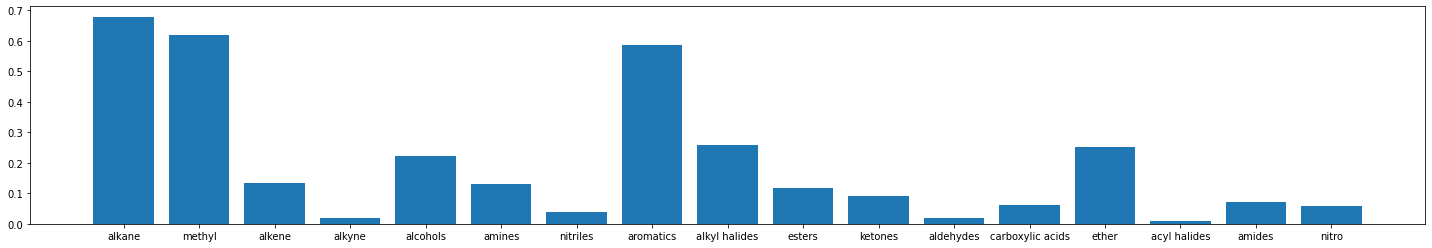

In [ ]:
plt.figure(figsize = (25,4))
plt.bar(groups_names, mean_of_groups[0])

Наблюдается сильный дисбаланс классов, что требует применения кроме бинарной кросс-энтропии для мультиклассовой модели, еще и правильного формирования батчей.